In [100]:
import rundec
from math import pi, modf, sqrt
from cmath import exp, log
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.special import zeta
from scipy.integrate import quad, odeint
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
crd = rundec.CRunDec()

In [10]:
# complex integration

    def real_func(x):
        return scipy.real(func(x))
    def imag_func(x):
        return scipy.imag(func(x))
    real_integral = quad(real_func, a, b, **kwargs)
    imag_integral = quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

# Plot spectral function for fitted parameters

In [2]:
with open('./alephData/alephVpA.json') as f:
    aleph_vpa = json.load(f)['data']
with open('./alephData/alephV.json') as f:
    aleph_v = json.load(f)['data']
with open('./alephData/alephA.json') as f:
    aleph_a = json.load(f)['data']
data = aleph_vpa
name = 'V+A'
alpha = 0.3232 #see fitting table in thesis for wKin (best Chi2)

In [34]:
mTau = 1.77682
sTau = mTau**2
BVpA = 51.116
Be = 17.815
Vud = 0.97425
SEW = 1.0201

def kinematicWeight(x):
    return (1-x)**2*(1+2*x)

def experimental_spectral_function(s, sfm2, ds):
    return sTau/12/pi**2/SEW/Vud**2/Be/kinematicWeight(s/sTau)/ds*sfm2

rho_vpa = list(map(lambda i: experimental_spectral_function(data['sbin'][i], data['sfm2'][i], data['dsbin'][i]), range(len(data['sbin']))))
rho_err_vpa = list(map(lambda i: experimental_spectral_function(data['sbin'][i], data['derr'][i], data['dsbin'][i]), range(len(data['sbin']))))
rho_v = list(map(lambda i: experimental_spectral_function(aleph_v['sbin'][i], aleph_v['sfm2'][i], aleph_v['dsbin'][i]), range(len(aleph_v['sbin']))))
rho_err_v = list(map(lambda i: experimental_spectral_function(aleph_v['sbin'][i], aleph_v['derr'][i], aleph_v['dsbin'][i]), range(len(aleph_v['sbin']))))

rho_a = list(map(lambda i: experimental_spectral_function(aleph_a['sbin'][i], aleph_a['sfm2'][i], aleph_a['dsbin'][i]), range(len(aleph_a['sbin']))))
rho_err_a = list(map(lambda i: experimental_spectral_function(aleph_a['sbin'][i], aleph_a['derr'][i], aleph_a['dsbin'][i]), range(len(aleph_a['sbin']))))

## Beta-function and Adler-function coefficients

In [6]:
nf = 3
nc = 3

b = np.zeros(5)
b[1] = 1/6*(11*nc - 2*nf)
b[2] = 51/4 - 19/12*nf
b[3] = 2857/64 - 5033/576*nf + 325/1728*nf**2
b[4] = 149753/768 + 891/32*zeta(3) -(1078361/20736 + 1627/864*zeta(3))*nf + (50065/20736 + 809/1296*zeta(3))*nf**2 + 1093/93312*nf**3

c = np.zeros((6,6))
c[0][0] = -5/3; c[0][1] = 1
c[1][1] = 1; c[1][2] = 0
c[2][1] = 365/24 - 11*zeta(3) - (11/12 - 2/3*zeta(3))*nf
c[2][2] = -b[1]*c[1][1]/4; c[2][3] = 0
c[3][1] = 87029/288 - 1103/4*zeta(3) + 275/6*zeta(5) +(-7847/216 + 262/9*zeta(3) -25/9*zeta(5))*nf + (151/162 -19/27 * zeta(3))*nf**2
c[3][2] = -1/4*(b[2]*c[1][1] + 2*b[1]*c[2][1])
c[3][3] = b[1]**2/12*c[1][1]; c[3][4] = 0;
c[4][1] = 78631453/20736 - 1704247/432*zeta(3) + 4185/8*zeta(3)**2 + 34165/96*zeta(5) - 1995/16*zeta(7)
c[4][2] = -1/4*(b[3]*c[1][1]+2*b[2]*c[2][1]+3*b[1]*c[3][1]);
c[4][3] = b[1]/24*(5*b[2]*c[1][1]+6*b[1]*c[2][1])
c[4][4] = -b[1]**3/32*c[1][1]; c[4][5] = 0
c[5][1] = 283
c[5][2] = 1/4*(-b[4]*c[1][1] - 2*b[3]*c[2][1]-3*b[2]*c[3][1]-4*b[1]*c[4][1]);
c[5][3] = 1/24*(12*c[3][1]*b[1]**2+6*b[1]*b[3]*c[1][1]+14*b[2]*b[1]*c[2][1]+3*b[2]**2*c[1][1]);
c[5][4] = 1/96*(-12*b[1]**3*c[2][1]-13*b[2]*b[1]**2*c[1][1])
c[5][5] = 1/80*b[1]**4*c[1][1]

## Theoretical spectral function

In [8]:
# following Jamin2008, Spectral function eq. 6 and e. 8
def theoretical_spectral_function_FOPT(s, alpha): # vector OR axial-vector contribution
    order = 3
    nSum = 0
    alphaRun = crd.AlphasExact(alpha, mTau, sqrt(s), 3, 5)/pi
    for n in range(1, order+1):
        lSum = 0
        for l in range(int(modf((n-1)/2)[1])+1):
            # sum = sum + (alpha/pi)**n*c[n][2*l+1]*(-pi**2)**l
            lSum = lSum + alphaRun**n*c[n][2*l+1]*(-pi**2)**l
        nSum = nSum + lSum

    # return nSum
    return nc/12/pi**2*(1 + nSum)

def theoretical_spectral_function_FOPT_VpA(s, alpha):
    return 2*theoretical_spectral_function_FOPT(s, alpha)

In [40]:
sLin = np.linspace(1, 3, 100)
th_func = list(map(lambda x: theoretical_spectral_function_FOPT(x, 0.329), sLin))
th_func_vpa = list(map(lambda x: theoretical_spectral_function_FOPT_VpA(x, 0.329), sLin))

## Vector

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


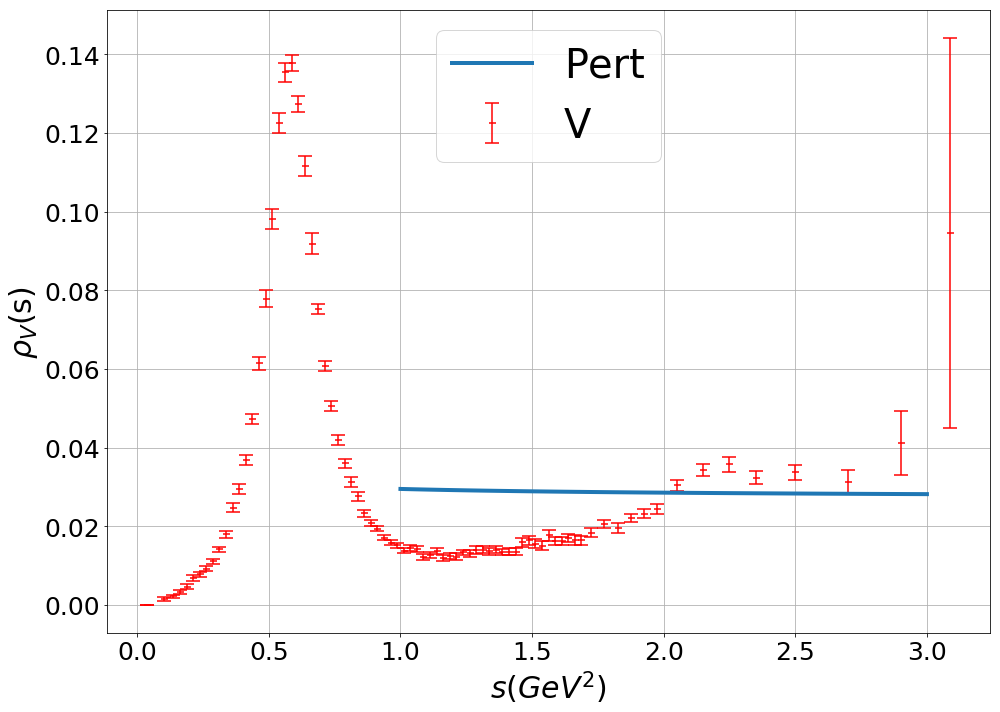

In [114]:
plt.errorbar(
    aleph_v['sbin'][:-1],
    rho_v[:-1],
    color='r',
    yerr=rho_err_v[:-1],
    capsize=7,
    fmt='_',
    mew=1.5,
    markersize=7,
    label='V'
)
plt.plot(
    sLin,
    scipy.real(th_func),
    linewidth=4,
    label='Pert'
)

fig = plt.gcf()
fig.set_size_inches(14, 10)
fig.patch.set_facecolor('white')

ax = plt.gca()
ax.tick_params(axis='both', labelsize=25)
ax.set_ylabel(r'$\rho_V$(s)', fontsize=30)
ax.set_xlabel('$s(GeV^2)$', fontsize=30)


plt.legend(prop={'size': 40})
plt.grid()
#plt.savefig(name+'.png', transparent=True)
plt.savefig('./../Thesis/chapters/tauDecaysIntoHadrons/images/specFuncAleph_V.eps',format='eps')

## Axial-vector

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


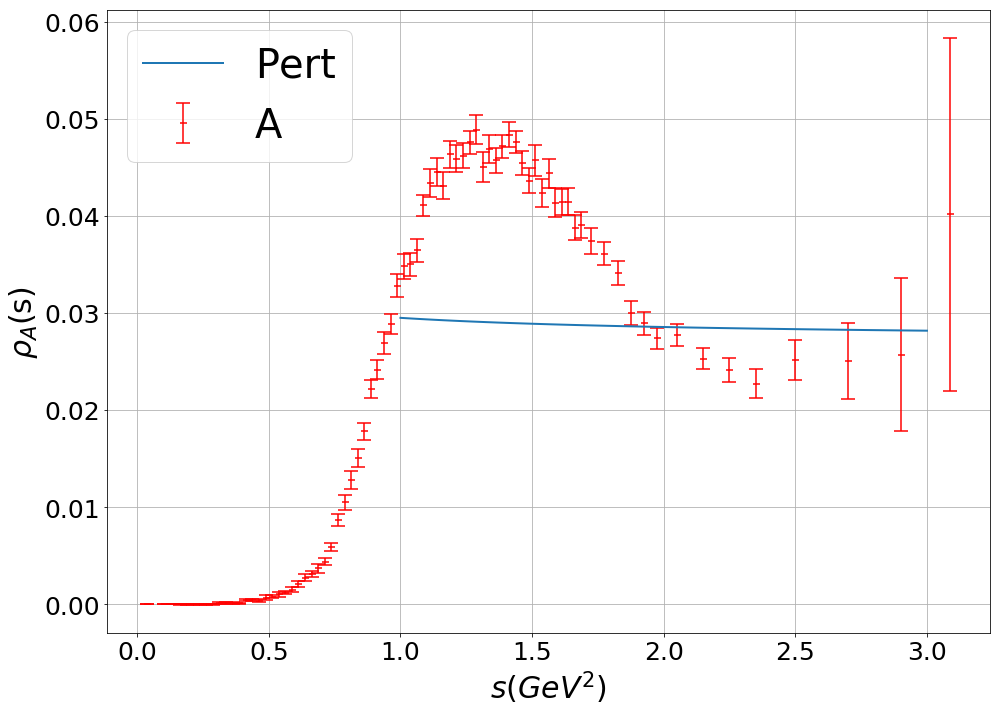

In [113]:
plt.errorbar(
    aleph_a['sbin'][:-1],
    rho_a[:-1],
    color='r',
    yerr=rho_err_a[:-1],
    capsize=7,
    fmt='_',
    mew=1.5,
    markersize=7,
    label='A'
)
plt.plot(
    sLin,
    scipy.real(th_func),
    linewidth=2,
    label='Pert'
)

fig = plt.gcf()
fig.set_size_inches(14, 10)
fig.patch.set_facecolor('white')

ax = plt.gca()
ax.tick_params(axis='both', labelsize=25)
ax.set_ylabel(r'$\rho_A$(s)', fontsize=30)
ax.set_xlabel('$s(GeV^2)$', fontsize=30)


plt.legend(prop={'size': 40})
plt.grid()

plt.savefig('./../Thesis/chapters/tauDecaysIntoHadrons/images/specFuncAleph_A.eps',format='eps')

## Vector- Plus Axial-Vector

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


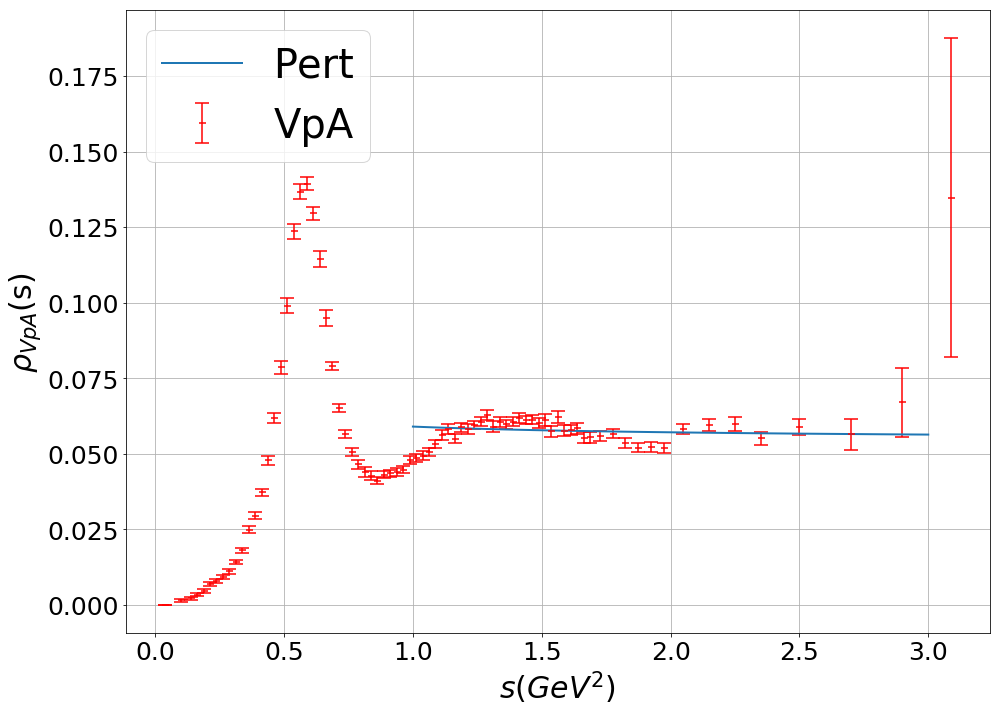

In [112]:
plt.errorbar(
    aleph_vpa['sbin'][:-1],
    rho_vpa[:-1],
    color='r',
    yerr=rho_err_vpa[:-1],
    capsize=7,
    fmt='_',
    mew=1.5,
    markersize=7,
    label='VpA'
)
plt.plot(
    sLin,
    scipy.real(th_func_vpa),
    linewidth=2,
    label='Pert'
)

fig = plt.gcf()
fig.set_size_inches(14, 10)
fig.patch.set_facecolor('white')
fig.tight_layout()

ax = plt.gca()
ax.tick_params(axis='both', labelsize=25)
ax.set_ylabel(r'$\rho_{VpA}$(s)', fontsize=30)
ax.set_xlabel('$s(GeV^2)$', fontsize=30)


plt.legend(prop={'size': 40})
plt.grid()

plt.savefig('./../Thesis/chapters/tauDecaysIntoHadrons/images/specFuncAleph_VpA.eps',format='eps')

In [103]:
def beta_function(a):
    return b[1]*a**2 + b[2]*a**3 + b[3]*a**4 + b[4]*a**5

0.47356652677240474


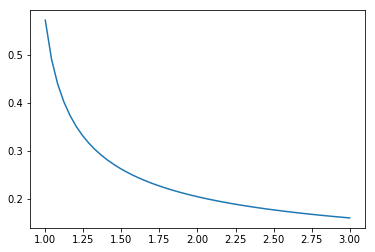

In [233]:
xLin = np.linspace(1, 3)
y = list(map(lambda x: crd.AlphasExact(0.323, sTau, sqrt(x), 3, 3)/pi, xLin))
plt.plot(xLin, y)
print(crd.AlphasExact(0.3156, mTau, 1, 3, 3))